In [25]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
import scipy.stats as ss
import csv
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
# Import custom libraries
import process_hic_contacts_inter as phc

In [26]:
# Reload modules in case of modifications
reload(phc)

<module 'process_hic_contacts_inter' from '/home/braunger/masterthesis/code/processing_hic/IMR90_hic_preprocessing/process_hic_contacts_inter.py'>

In [38]:
# Specify directories and relevant information
genome_dir = '/home/braunger/masterthesis/data/genome_data/'
processed_hic_dir = '/home/braunger/masterthesis/save/processed_hic_data/'
saving_dir = '/home/braunger/masterthesis/save/figures/hic_processing/'
cell_type = 'IMR90'
resol = 250000
quality = 'MAPQGE30'
norm = 'INTERKR'
chr1 = 1
chr2 = 2

### Load data

In [39]:
# Load normalized HiC data
normalized_hic_data = phc.get_normed_hic_sparse(processed_hic_dir, cell_type, resol, quality, chr1, chr2, norm)
normalized_hic_data.head()

,locus_chr1,locus_chr2,norm_value
0,2,0,39.149170
1,3,0,2.655160
2,5,0,1.406964
3,6,0,1.588467
4,7,0,4.906548


In [40]:
# Get chromosome sizes
df_sizes = phc.get_chrom_sizes(genome_dir,resol)
chr1_size = int(df_sizes[df_sizes['chr']==str(chr1)]['size_loci'])
chr2_size = int(df_sizes[df_sizes['chr']==str(chr2)]['size_loci'])
df_sizes.head()

,chr,size,size_loci,size_roundup
0,1,249250621,998,249500000
1,2,243199373,973,243250000
2,3,198022430,793,198250000
3,4,191154276,765,191250000
4,5,180915260,724,181000000


In [41]:
# Get dense HiC dataframe
df = phc.get_dense_hic_dataframe(normalized_hic_data, chr1_size, chr2_size, resol)
df.head()

,0,250000,500000,750000,1000000,1250000,1500000,1750000,2000000,2250000,...,240750000,241000000,241250000,241500000,241750000,242000000,242250000,242500000,242750000,243000000
0,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,57.269142,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
250000,0.00000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
500000,39.14917,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,...,27.125702,0.000000,0.000000,0.000000,0.000000,0.000000,20.627766,22.082020,89.965010,0.000000
750000,2.65516,0.000000,0.0,1.675982,0.0,1.622502,5.475832,0.0,1.801367,1.631483,...,1.839709,3.415667,5.304751,4.851744,3.865977,9.332703,7.694546,14.227563,30.507862,26.738092
1000000,0.00000,1.657482,0.0,3.867542,0.0,0.000000,1.263618,0.0,2.078441,0.000000,...,1.061340,6.896824,1.020115,5.598007,5.575769,8.076147,9.685166,17.279947,8.800094,10.283588


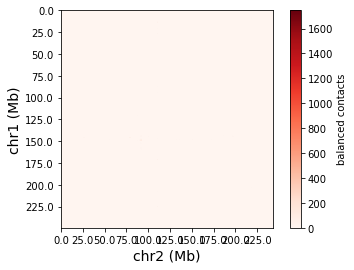

In [42]:
# Plot HiC dense dataframe
%matplotlib inline
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir, show=True)

In [43]:
# All-0 rows and columns
print(f'All-0 rows = {df.index.to_series()[df.sum(axis=1)==0].index.values}')
print(f'All-0 columns = {df.columns.to_series()[df.sum(axis=0)==0].index.values}')

All-0 rows = [   250000  13250000  13500000 121500000 121750000 122000000 122250000
 122500000 122750000 123000000 123250000 123500000 123750000 124000000
 124250000 124500000 124750000 125000000 125250000 125500000 125750000
 126000000 126250000 126500000 126750000 127000000 127250000 127500000
 127750000 128000000 128250000 128500000 128750000 129000000 129250000
 129500000 129750000 130000000 130250000 130500000 130750000 131000000
 131250000 131500000 131750000 132000000 132250000 132500000 132750000
 133000000 133250000 133500000 133750000 134000000 134250000 134500000
 134750000 135000000 135250000 135500000 135750000 136000000 136250000
 136500000 136750000 137000000 137250000 137500000 137750000 138000000
 138250000 138500000 138750000 139000000 139250000 139500000 139750000
 140000000 140250000 140500000 140750000 141000000 141250000 141500000
 141750000 142000000 142250000 249250000]
All-0 columns = [90500000 90750000 91000000 91250000 92500000 92750000 93000000 93250000
 935

### Filter out centromeres

In [44]:
# Get centromere locations
df_centrom = phc.get_centromere_locations(genome_dir)
df_centrom.head()

,bin,chrom,chromStart,chromEnd,ix,n,size,type,bridge
0,23,chr1,121535434,124535434,1270,N,3000000,centromere,no
1,20,chr2,92326171,95326171,770,N,3000000,centromere,no
2,2,chr3,90504854,93504854,784,N,3000000,centromere,no
3,1,chr4,49660117,52660117,447,N,3000000,centromere,no
4,14,chr5,46405641,49405641,452,N,3000000,centromere,no


In [45]:
# Filter out centromeres
filter_size = 2000000
df = phc.filter_centromeres(df, chr1, 'row', df_centrom, filter_size, resol)
df = phc.filter_centromeres(df, chr2, 'col', df_centrom, filter_size, resol)

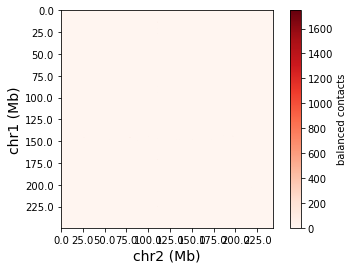

In [46]:
# Plot HiC data after filtering out centromeres
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir, show=True)

### Filter out repeats

In [47]:
# Load repeats data
df_repeats = phc.load_repeats_data(genome_dir)
df_repeats.head()

,genoname,genoStart,genoEnd,repLength
0,chr1,10000,10468,468
1,chr1,10468,11447,979
2,chr1,11503,11675,172
3,chr1,11677,11780,103
4,chr1,15264,15355,91


In [48]:
# Find repeat-covered loci to filter out
chr_list = np.arange(1, 22+1)
dic_repeats_tofilter = phc.find_repeat_locations(df_repeats, chr_list, df_sizes, resol)

In [49]:
# Filter repeats for chr1 and chr2
df = phc.filter_repeats(df, chr1, dic_repeats_tofilter, 'row')
df = phc.filter_repeats(df, chr2, dic_repeats_tofilter, 'col')

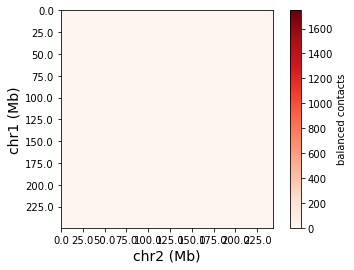

In [50]:
# Plot HiC data after filtering out repeats
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df, chr1, chr2, plotname, hic_plots_dir, show=True)

## Log-transform and filter out outliers

In [51]:
# Log-transform dataframe
df_transformed = phc.log_transform(df)

In [52]:
# Filter out outliers
df_transformed, _, _ = phc.filter_outliers(df_transformed)
#df_transformed = df_transformed*(df_transformed<1)

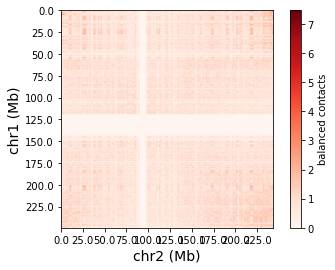

In [53]:
# Plot HiC data after filtering out centromeres, repeats and outliers
plotname = ''
hic_plots_dir = ''
phc.plot_dense_hic_dataframe(df_transformed, chr1, chr2, plotname, hic_plots_dir, show=True)

In [23]:
x = df_transformed.values.flatten()
x = x[x>0]
x

array([0.69314718, 0.69314718, 0.69314718, ..., 2.19722458, 2.56494936,
       2.07944154])

In [24]:
# Record nonzero entries
data = df_transformed.values
data_nonzero = data[np.nonzero(data)]

### Blacklisted locations

In [27]:
df = df_transformed.copy()

In [28]:
# Initialize empty dictionary
blacklist = defaultdict(list)

In [29]:
# Compute loci with zero values for chromosomes chr1 and chr2
zero_cols = df.columns[(df == 0).all(axis=0)]
blacklist[chr2].append(zero_cols)
zero_rows = df.index[(df == 0).all(axis=1)]
blacklist[chr1].append(zero_rows)

In [30]:
# Process the dicitonary
for chrom in blacklist.keys():
    values_list = blacklist[chrom]
    blacklist[chrom] = set(map(int, list(itertools.chain.from_iterable(values_list))))